In [1]:
# carregamento de bibliotecas
import os
import sys
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
# Adiciona a pasta raiz do projeto (onde está a pasta src) ao sys.path
sys.path.append(os.path.abspath(os.path.join("..")))
from src.config.logging_config import setup_logging
from src.model.train import *


In [2]:
# configuração do logging
setup_logging()

In [3]:
# carregamento do dataset processado
tbl_cotacao_ibovespa = pd.read_csv('../data/processed/tbl_cotacao_ibovespa_processed.csv',index_col=0, parse_dates=True)
tbl_cotacao_ibovespa.index = tbl_cotacao_ibovespa.index.tz_localize(None)
tbl_cotacao_ibovespa.head()

,ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits,trailingPE,priceToBook,...,lag_1_Close_diff,lag_2_Close_diff,lag_3_Close_diff,lag_5_Close_diff,rolling_mean_3_Close_diff,volatility_3_Close_diff,retorno_acumulado_3_Close_diff,rolling_mean_5_Close_diff,volatility_5_Close_diff,retorno_acumulado_5_Close_diff
Date,,,,,,,,,,,,,,,,,,,,,
2025-07-15,ABEV3,13.37,13.52,13.23,13.27,27675300,0.0,0.0,13.215054,2.034432,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-16,ABEV3,13.38,13.73,13.31,13.68,48903600,0.0,0.0,13.215054,2.034432,...,-0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-17,ABEV3,13.67,13.69,13.44,13.46,19213600,0.0,0.0,13.215054,2.034432,...,0.41,-0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-18,ABEV3,13.33,13.49,13.29,13.32,23902900,0.0,0.0,13.215054,2.034432,...,-0.22,0.41,-0.02,NaN,0.056667,0.321921,0.170000,NaN,NaN,NaN
2025-07-21,ABEV3,13.35,13.45,13.26,13.42,21355000,0.0,0.0,13.215054,2.034432,...,-0.14,-0.22,0.41,NaN,0.016666,0.342977,0.049999,NaN,NaN,NaN


In [33]:
tbl_cotacao_ibovespa.index[1].dayofweek

2

In [29]:
tbl_cotacao_ibovespa.index.dayofweek.unique()

Index([1, 2, 3, 4, 0], dtype='int32', name='Date')

In [262]:
# separação dos dados em treino e teste 
colunas_com_diferenciacao = ['Close','lag_1_Close', 'lag_2_Close',
       'lag_3_Close', 'lag_5_Close', 'rolling_mean_3_Close',
       'volatility_3_Close', 'retorno_acumulado_3_Close',
       'rolling_mean_5_Close', 'volatility_5_Close',
       'retorno_acumulado_5_Close', 'Dividends',
       'Stock Splits', 'trailingPE', 'priceToBook', 'returnOnEquity',
       'profitMargins', 'revenueGrowth', 'dividendYield', 'totalDebt',
       'freeCashflow', 'tipo', 'setor', 'industria', 'dayofweek', 'month',]

# filtragem do dataset com as colunas para os modelos sem diferenciação
tbl_cotacao_ibovespa_filt = tbl_cotacao_ibovespa.drop(columns=colunas_com_diferenciacao, axis=1)

y = tbl_cotacao_ibovespa['Close_diff']
X_treino, X_teste,y_treino,y_teste = separar_dados_treino_teste_loc_acao(df=tbl_cotacao_ibovespa_filt, target='Close_diff',coluna_acao='ticker')


2025-08-04 20:07:00,759 | INFO | src.model.train | Iniciando a separação dos dados em treino e teste por ação.
2025-08-04 20:07:00,798 | INFO | src.model.train | Separação concluída. X_train: (504, 20), X_test: (252, 20), y_train: (504,), y_test: (252,)


sarimax - target encoding(ticker), onehotencoding e definir exog 
xgboost - target encoding(ticker), onehotencoding - com diferenciacao
catboost - faz oh internamente 
random forest - target encoding(ticker), onehotencoding 


In [263]:
# pré-processamento dos dados: target encoding, onehot encoding e transformação e scaler. 

# separação das colunas categoricas 
cols_cat_oh = ['tipo', 'setor', 'industria']

# separação das colunas numéricas para simple imputer com a média, trasformação yeo-johnson e scaler para colunas numéricas.
cols_nums = ['Open', 'High', 'Low', 'Volume', 'Feriado', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
       'lag_1_Close_diff', 'lag_2_Close_diff', 'lag_3_Close_diff',
       'lag_5_Close_diff', 'rolling_mean_3_Close_diff',
       'volatility_3_Close_diff', 'retorno_acumulado_3_Close_diff',
       'rolling_mean_5_Close_diff', 'volatility_5_Close_diff',
       'retorno_acumulado_5_Close_diff']

# target encoder inserido na função
preprocessor = criar_preprocessor(target_encoder='ticker', colunas_categoricas_onehot=cols_cat_oh, colunas_numericas=cols_nums)
preprocessor

2025-08-04 20:07:00,816 | INFO | src.model.train | Iniciando construção do pipeline de pré-processamento.
2025-08-04 20:07:00,817 | INFO | src.model.train | Pipeline de pré-processamento construído com sucesso.


,transformers,"[('target_encoder_ticker', ...), ('onehot_encoder_others', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,verbose,0
,cols,['ticker']
,drop_invariant,False


In [264]:
# treino do modelo sarimax
feat_exog = [
    'Open', 'High', 'Low', 'Volume', 'Feriado', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
    'lag_1_Close_diff', 'lag_2_Close_diff', 'lag_3_Close_diff',
    'lag_5_Close_diff', 'rolling_mean_3_Close_diff',
    'volatility_3_Close_diff', 'retorno_acumulado_3_Close_diff',
    'rolling_mean_5_Close_diff', 'volatility_5_Close_diff',
    'retorno_acumulado_5_Close_diff'
]


# junção do dataset de treino
dataset_treino = pd.concat([X_treino, y_treino], axis=1)
#dataset_treino.drop(columns=['setor','industria','tipo'], axis=1, inplace=True)
# tratamento de valores nulos

colunas_para_imputar = dataset_treino.select_dtypes(include=['float64', 'int64']).columns

# Itera sobre as colunas numéricas e imputa usando a média de cada grupo
for col in colunas_para_imputar:
    dataset_treino[col] = dataset_treino.groupby('ticker')[col].transform(lambda x: x.fillna(x.mean()))

dataset_treino


,ticker,Open,High,Low,Volume,Feriado,day_sin,day_cos,month_sin,month_cos,...,lag_2_Close_diff,lag_3_Close_diff,lag_5_Close_diff,rolling_mean_3_Close_diff,volatility_3_Close_diff,retorno_acumulado_3_Close_diff,rolling_mean_5_Close_diff,volatility_5_Close_diff,retorno_acumulado_5_Close_diff,Close_diff
Date,,,,,,,,,,,,,,,,,,,,,
2025-07-15,ABEV3,13.37,13.52,13.23,27675300,0,0.951057,0.309017,-0.5,-0.866025,...,0.007500,0.056667,-0.02,-0.004445,0.277144,-0.013334,0.026,0.246536,0.13,-0.020000
2025-07-16,ABEV3,13.38,13.73,13.31,48903600,0,0.587785,-0.809017,-0.5,-0.866025,...,0.007500,0.056667,-0.02,-0.004445,0.277144,-0.013334,0.026,0.246536,0.13,0.410000
2025-07-17,ABEV3,13.67,13.69,13.44,19213600,0,-0.587785,-0.809017,-0.5,-0.866025,...,-0.020000,0.056667,-0.02,-0.004445,0.277144,-0.013334,0.026,0.246536,0.13,-0.220000
2025-07-18,ABEV3,13.33,13.49,13.29,23902900,0,-0.951057,0.309017,-0.5,-0.866025,...,0.410000,-0.020000,-0.02,0.056667,0.321921,0.170000,0.026,0.246536,0.13,-0.140000
2025-07-21,ABEV3,13.35,13.45,13.26,21355000,0,0.000000,1.000000,-0.5,-0.866025,...,-0.220000,0.410000,-0.02,0.016666,0.342977,0.049999,0.026,0.246536,0.13,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-16,YDUQ3,14.19,14.32,13.57,4784400,0,0.587785,-0.809017,-0.5,-0.866025,...,-0.137500,0.173333,0.37,-0.171111,0.482100,-0.513334,-0.144,0.552159,-0.72,0.050000
2025-07-17,YDUQ3,14.21,14.38,13.98,2807800,0,-0.587785,-0.809017,-0.5,-0.866025,...,0.370000,0.173333,0.37,-0.171111,0.482100,-0.513334,-0.144,0.552159,-0.72,0.099999
2025-07-18,YDUQ3,14.20,14.28,13.18,8427900,0,-0.951057,0.309017,-0.5,-0.866025,...,0.050000,0.370000,0.37,0.173333,0.172143,0.520000,-0.144,0.552159,-0.72,-1.070000


In [265]:
# treino do modelo sarimax para cada ação
modelo_sarimax = treinar_sarimax_por_acao_com_exog(df=dataset_treino, coluna_acao='ticker', coluna_target='Close_diff', colunas_exogenas=feat_exog)

2025-08-04 20:07:02,511 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: ABEV3
2025-08-04 20:07:02,564 | INFO | src.model.train | Modelo SARIMAX para ABEV3 treinado com sucesso.
2025-08-04 20:07:02,566 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: ALOS3
2025-08-04 20:07:02,607 | INFO | src.model.train | Modelo SARIMAX para ALOS3 treinado com sucesso.
2025-08-04 20:07:02,608 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: ASAI3
2025-08-04 20:07:02,653 | INFO | src.model.train | Modelo SARIMAX para ASAI3 treinado com sucesso.
2025-08-04 20:07:02,654 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: AURE3
2025-08-04 20:07:02,712 | INFO | src.model.train | Modelo SARIMAX para AURE3 treinado com sucesso.


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

2025-08-04 20:07:02,713 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: AZZA3
2025-08-04 20:07:02,762 | INFO | src.model.train | Modelo SARIMAX para AZZA3 treinado com sucesso.
2025-08-04 20:07:02,762 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: B3SA3
2025-08-04 20:07:02,809 | INFO | src.model.train | Modelo SARIMAX para B3SA3 treinado com sucesso.
2025-08-04 20:07:02,810 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: BBAS3
2025-08-04 20:07:02,853 | INFO | src.model.train | Modelo SARIMAX para BBAS3 treinado com sucesso.
2025-08-04 20:07:02,854 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: BBDC3
2025-08-04 20:07:02,896 | INFO | src.model.train | Modelo SARIMAX para BBDC3 treinado com sucesso.
2025-08-04 20:07:02,898 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: BBDC4


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

2025-08-04 20:07:02,948 | INFO | src.model.train | Modelo SARIMAX para BBDC4 treinado com sucesso.
2025-08-04 20:07:02,949 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: BBSE3
2025-08-04 20:07:02,995 | INFO | src.model.train | Modelo SARIMAX para BBSE3 treinado com sucesso.
2025-08-04 20:07:02,996 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: BEEF3
2025-08-04 20:07:03,042 | INFO | src.model.train | Modelo SARIMAX para BEEF3 treinado com sucesso.
2025-08-04 20:07:03,043 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: BPAC11
2025-08-04 20:07:03,088 | INFO | src.model.train | Modelo SARIMAX para BPAC11 treinado com sucesso.
2025-08-04 20:07:03,089 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: BRAP4
2025-08-04 20:07:03,140 | INFO | src.model.train | Modelo SARIMAX para BRAP4 treinado com sucesso.


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inf

2025-08-04 20:07:03,140 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: BRAV3
2025-08-04 20:07:03,204 | INFO | src.model.train | Modelo SARIMAX para BRAV3 treinado com sucesso.
2025-08-04 20:07:03,205 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: BRFS3
2025-08-04 20:07:03,272 | INFO | src.model.train | Modelo SARIMAX para BRFS3 treinado com sucesso.
2025-08-04 20:07:03,273 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: BRKM5


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

2025-08-04 20:07:03,335 | INFO | src.model.train | Modelo SARIMAX para BRKM5 treinado com sucesso.
2025-08-04 20:07:03,336 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: CMIG4
2025-08-04 20:07:03,387 | INFO | src.model.train | Modelo SARIMAX para CMIG4 treinado com sucesso.
2025-08-04 20:07:03,388 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: CMIN3
2025-08-04 20:07:03,429 | INFO | src.model.train | Modelo SARIMAX para CMIN3 treinado com sucesso.
2025-08-04 20:07:03,429 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: COGN3
2025-08-04 20:07:03,474 | INFO | src.model.train | Modelo SARIMAX para COGN3 treinado com sucesso.
2025-08-04 20:07:03,475 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: CPFE3
2025-08-04 20:07:03,517 | INFO | src.model.train | Modelo SARIMAX para CPFE3 treinado com sucesso.
2025-08-04 20:07:03,518 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: CPLE6
2025-08-04 20:07:03,561 | INFO

c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

2025-08-04 20:07:03,561 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: CSAN3
2025-08-04 20:07:03,612 | INFO | src.model.train | Modelo SARIMAX para CSAN3 treinado com sucesso.
2025-08-04 20:07:03,612 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: CSNA3
2025-08-04 20:07:03,659 | INFO | src.model.train | Modelo SARIMAX para CSNA3 treinado com sucesso.
2025-08-04 20:07:03,660 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: CVCB3
2025-08-04 20:07:03,713 | INFO | src.model.train | Modelo SARIMAX para CVCB3 treinado com sucesso.
2025-08-04 20:07:03,714 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: CXSE3
2025-08-04 20:07:03,756 | INFO | src.model.train | Modelo SARIMAX para CXSE3 treinado com sucesso.


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

2025-08-04 20:07:03,757 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: CYRE3
2025-08-04 20:07:03,806 | INFO | src.model.train | Modelo SARIMAX para CYRE3 treinado com sucesso.
2025-08-04 20:07:03,807 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: DIRR3
2025-08-04 20:07:03,849 | INFO | src.model.train | Modelo SARIMAX para DIRR3 treinado com sucesso.
2025-08-04 20:07:03,850 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: EGIE3
2025-08-04 20:07:03,896 | INFO | src.model.train | Modelo SARIMAX para EGIE3 treinado com sucesso.
2025-08-04 20:07:03,898 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: ELET3
2025-08-04 20:07:03,941 | INFO | src.model.train | Modelo SARIMAX para ELET3 treinado com sucesso.


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

2025-08-04 20:07:03,942 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: ELET6
2025-08-04 20:07:03,992 | INFO | src.model.train | Modelo SARIMAX para ELET6 treinado com sucesso.
2025-08-04 20:07:03,994 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: EMBR3
2025-08-04 20:07:04,090 | INFO | src.model.train | Modelo SARIMAX para EMBR3 treinado com sucesso.
2025-08-04 20:07:04,093 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: ENEV3


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

2025-08-04 20:07:04,171 | INFO | src.model.train | Modelo SARIMAX para ENEV3 treinado com sucesso.
2025-08-04 20:07:04,173 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: ENGI11
2025-08-04 20:07:04,222 | INFO | src.model.train | Modelo SARIMAX para ENGI11 treinado com sucesso.
2025-08-04 20:07:04,223 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: EQTL3
2025-08-04 20:07:04,272 | INFO | src.model.train | Modelo SARIMAX para EQTL3 treinado com sucesso.
2025-08-04 20:07:04,273 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: FLRY3
2025-08-04 20:07:04,320 | INFO | src.model.train | Modelo SARIMAX para FLRY3 treinado com sucesso.
2025-08-04 20:07:04,321 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: GGBR4


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inf

2025-08-04 20:07:04,366 | INFO | src.model.train | Modelo SARIMAX para GGBR4 treinado com sucesso.
2025-08-04 20:07:04,368 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: GOAU4
2025-08-04 20:07:04,412 | INFO | src.model.train | Modelo SARIMAX para GOAU4 treinado com sucesso.
2025-08-04 20:07:04,413 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: HAPV3
2025-08-04 20:07:04,458 | INFO | src.model.train | Modelo SARIMAX para HAPV3 treinado com sucesso.
2025-08-04 20:07:04,459 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: HYPE3
2025-08-04 20:07:04,506 | INFO | src.model.train | Modelo SARIMAX para HYPE3 treinado com sucesso.
2025-08-04 20:07:04,507 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: IGTI11
2025-08-04 20:07:04,548 | INFO | src.model.train | Modelo SARIMAX para IGTI11 treinado com sucesso.
2025-08-04 20:07:04,549 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: IRBR3


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

2025-08-04 20:07:04,594 | INFO | src.model.train | Modelo SARIMAX para IRBR3 treinado com sucesso.
2025-08-04 20:07:04,595 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: ISAE4
2025-08-04 20:07:04,642 | INFO | src.model.train | Modelo SARIMAX para ISAE4 treinado com sucesso.
2025-08-04 20:07:04,643 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: ITSA4
2025-08-04 20:07:04,688 | INFO | src.model.train | Modelo SARIMAX para ITSA4 treinado com sucesso.
2025-08-04 20:07:04,689 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: ITUB4
2025-08-04 20:07:04,731 | INFO | src.model.train | Modelo SARIMAX para ITUB4 treinado com sucesso.
2025-08-04 20:07:04,732 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: KLBN11
2025-08-04 20:07:04,776 | INFO | src.model.train | Modelo SARIMAX para KLBN11 treinado com sucesso.
2025-08-04 20:07:04,777 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: LREN3


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inf

2025-08-04 20:07:04,824 | INFO | src.model.train | Modelo SARIMAX para LREN3 treinado com sucesso.
2025-08-04 20:07:04,825 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: MGLU3
2025-08-04 20:07:04,869 | INFO | src.model.train | Modelo SARIMAX para MGLU3 treinado com sucesso.
2025-08-04 20:07:04,869 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: MOTV3
2025-08-04 20:07:04,913 | INFO | src.model.train | Modelo SARIMAX para MOTV3 treinado com sucesso.
2025-08-04 20:07:04,913 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: MRFG3
2025-08-04 20:07:04,959 | INFO | src.model.train | Modelo SARIMAX para MRFG3 treinado com sucesso.
2025-08-04 20:07:04,960 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: MRVE3


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

2025-08-04 20:07:05,007 | INFO | src.model.train | Modelo SARIMAX para MRVE3 treinado com sucesso.
2025-08-04 20:07:05,009 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: MULT3
2025-08-04 20:07:05,052 | INFO | src.model.train | Modelo SARIMAX para MULT3 treinado com sucesso.
2025-08-04 20:07:05,053 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: NATU3
2025-08-04 20:07:05,093 | INFO | src.model.train | Modelo SARIMAX para NATU3 treinado com sucesso.
2025-08-04 20:07:05,094 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: PCAR3
2025-08-04 20:07:05,138 | INFO | src.model.train | Modelo SARIMAX para PCAR3 treinado com sucesso.
2025-08-04 20:07:05,139 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: PETR3
2025-08-04 20:07:05,180 | INFO | src.model.train | Modelo SARIMAX para PETR3 treinado com sucesso.
2025-08-04 20:07:05,181 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: PETR4


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inf

2025-08-04 20:07:05,228 | INFO | src.model.train | Modelo SARIMAX para PETR4 treinado com sucesso.
2025-08-04 20:07:05,229 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: PETZ3
2025-08-04 20:07:05,278 | INFO | src.model.train | Modelo SARIMAX para PETZ3 treinado com sucesso.
2025-08-04 20:07:05,280 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: POMO4
2025-08-04 20:07:05,326 | INFO | src.model.train | Modelo SARIMAX para POMO4 treinado com sucesso.
2025-08-04 20:07:05,327 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: PRIO3
2025-08-04 20:07:05,372 | INFO | src.model.train | Modelo SARIMAX para PRIO3 treinado com sucesso.


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

2025-08-04 20:07:05,373 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: PSSA3
2025-08-04 20:07:05,418 | INFO | src.model.train | Modelo SARIMAX para PSSA3 treinado com sucesso.
2025-08-04 20:07:05,419 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: RADL3
2025-08-04 20:07:05,468 | INFO | src.model.train | Modelo SARIMAX para RADL3 treinado com sucesso.
2025-08-04 20:07:05,469 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: RAIL3
2025-08-04 20:07:05,511 | INFO | src.model.train | Modelo SARIMAX para RAIL3 treinado com sucesso.
2025-08-04 20:07:05,511 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: RAIZ4
2025-08-04 20:07:05,556 | INFO | src.model.train | Modelo SARIMAX para RAIZ4 treinado com sucesso.
2025-08-04 20:07:05,557 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: RDOR3


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

2025-08-04 20:07:05,600 | INFO | src.model.train | Modelo SARIMAX para RDOR3 treinado com sucesso.
2025-08-04 20:07:05,602 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: RECV3
2025-08-04 20:07:05,649 | INFO | src.model.train | Modelo SARIMAX para RECV3 treinado com sucesso.
2025-08-04 20:07:05,649 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: RENT3
2025-08-04 20:07:05,698 | INFO | src.model.train | Modelo SARIMAX para RENT3 treinado com sucesso.
2025-08-04 20:07:05,699 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: SANB11
2025-08-04 20:07:05,745 | INFO | src.model.train | Modelo SARIMAX para SANB11 treinado com sucesso.
2025-08-04 20:07:05,746 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: SBSP3
2025-08-04 20:07:05,790 | INFO | src.model.train | Modelo SARIMAX para SBSP3 treinado com sucesso.
2025-08-04 20:07:05,790 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: SLCE3


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

2025-08-04 20:07:05,853 | INFO | src.model.train | Modelo SARIMAX para SLCE3 treinado com sucesso.
2025-08-04 20:07:05,855 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: SMFT3
2025-08-04 20:07:05,899 | INFO | src.model.train | Modelo SARIMAX para SMFT3 treinado com sucesso.
2025-08-04 20:07:05,900 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: SMTO3
2025-08-04 20:07:05,945 | INFO | src.model.train | Modelo SARIMAX para SMTO3 treinado com sucesso.
2025-08-04 20:07:05,947 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: STBP3


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inf

2025-08-04 20:07:06,051 | INFO | src.model.train | Modelo SARIMAX para STBP3 treinado com sucesso.
2025-08-04 20:07:06,054 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: SUZB3
2025-08-04 20:07:06,126 | INFO | src.model.train | Modelo SARIMAX para SUZB3 treinado com sucesso.
2025-08-04 20:07:06,127 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: TAEE11
2025-08-04 20:07:06,173 | INFO | src.model.train | Modelo SARIMAX para TAEE11 treinado com sucesso.
2025-08-04 20:07:06,174 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: TIMS3
2025-08-04 20:07:06,218 | INFO | src.model.train | Modelo SARIMAX para TIMS3 treinado com sucesso.
2025-08-04 20:07:06,219 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: TOTS3
2025-08-04 20:07:06,261 | INFO | src.model.train | Modelo SARIMAX para TOTS3 treinado com sucesso.


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

2025-08-04 20:07:06,262 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: UGPA3
2025-08-04 20:07:06,307 | INFO | src.model.train | Modelo SARIMAX para UGPA3 treinado com sucesso.
2025-08-04 20:07:06,308 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: USIM5
2025-08-04 20:07:06,353 | INFO | src.model.train | Modelo SARIMAX para USIM5 treinado com sucesso.
2025-08-04 20:07:06,355 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: VALE3
2025-08-04 20:07:06,400 | INFO | src.model.train | Modelo SARIMAX para VALE3 treinado com sucesso.
2025-08-04 20:07:06,401 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: VAMO3
2025-08-04 20:07:06,446 | INFO | src.model.train | Modelo SARIMAX para VAMO3 treinado com sucesso.
2025-08-04 20:07:06,448 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: VBBR3


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

2025-08-04 20:07:06,495 | INFO | src.model.train | Modelo SARIMAX para VBBR3 treinado com sucesso.
2025-08-04 20:07:06,497 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: VIVA3
2025-08-04 20:07:06,543 | INFO | src.model.train | Modelo SARIMAX para VIVA3 treinado com sucesso.
2025-08-04 20:07:06,543 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: VIVT3
2025-08-04 20:07:06,592 | INFO | src.model.train | Modelo SARIMAX para VIVT3 treinado com sucesso.
2025-08-04 20:07:06,592 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: WEGE3
2025-08-04 20:07:06,638 | INFO | src.model.train | Modelo SARIMAX para WEGE3 treinado com sucesso.
2025-08-04 20:07:06,639 | INFO | src.model.train | Treinando modelo SARIMAX para a ação: YDUQ3
2025-08-04 20:07:06,684 | INFO | src.model.train | Modelo SARIMAX para YDUQ3 treinado com sucesso.


c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ederr\Documents\PROJETOS_PYTHON\projetos_fiap\Fase_2\etl-aws\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inf

In [266]:
# concatenação dos dados de teste para validação de resultado
dataset_teste = pd.concat([X_teste,y_teste], axis=1)

In [267]:
# armazenar as previsões dos modelos

previsoes = {}

for ticker, modelo in modelo_sarimax.items():

    # filtra os dados de teste para a ação atual
    df_teste_acao = dataset_teste[dataset_teste['ticker'] == ticker]
    
    # 2. Define o número de passos para a previsão
    steps = len(df_teste_acao)
    
    # 3. Extrai APENAS os dados exógenos da ação atual
    # A correção crucial está aqui: usar 'df_teste_acao' em vez de 'dataset_teste'
    X_teste_acao = df_teste_acao[feat_exog]
    
    # 4. Realiza a previsão
    previsao = modelo.get_forecast(steps=steps, exog=X_teste_acao)
    
    # 5. Salva o resultado da previsão
    previsoes[ticker] = previsao.predicted_mean



In [268]:
# Supondo que 'df_teste' é o seu DataFrame de teste, e 'previsoes' é o dicionário de previsões
# Vamos criar um DataFrame de resultados para facilitar a avaliação
resultados_avaliacao = pd.DataFrame(columns=['ticker', 'real', 'previsao'])

# Itere sobre o dicionário de previsões para popular o DataFrame
for ticker, previsao_serie in previsoes.items():
    # Pega os valores reais do DataFrame de teste para o ticker atual
    valores_reais = dataset_teste[dataset_teste['ticker'] == ticker]['Close_diff']
    
    # Cria um DataFrame temporário para os resultados da ação
    temp_df = pd.DataFrame({
        'ticker': ticker,
        'real': valores_reais.values,
        'previsao': previsao_serie.values
    })
    
    # Adiciona ao DataFrame principal
    resultados_avaliacao = pd.concat([resultados_avaliacao, temp_df], ignore_index=True)

# Visualize o resultado
len(resultados_avaliacao.ticker)

C:\Users\ederr\AppData\Local\Temp\ipykernel_8328\2184649920.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultados_avaliacao = pd.concat([resultados_avaliacao, temp_df], ignore_index=True)


252

In [269]:
# métricas de performance do modelo
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
# Erro Quadrático Médio (RMSE)
rmse_geral = root_mean_squared_error(resultados_avaliacao['real'], resultados_avaliacao['previsao'])

# Erro Médio Absoluto (MAE)
mae_geral = mean_absolute_error(resultados_avaliacao['real'], resultados_avaliacao['previsao'])

r2_geral = r2_score(resultados_avaliacao['real'], resultados_avaliacao['previsao'])

print(f"RMSE Geral: {rmse_geral:.4f}")
print(f"MAE Geral: {mae_geral:.4f}")
print(f"r2 Geral: {r2_geral:.4f}")




RMSE Geral: 0.9093
MAE Geral: 0.5925
r2 Geral: -2.6676


            RMSE       MAE
ticker                    
ABEV3   0.483834  0.440173
ALOS3   0.161431  0.134185
ASAI3   0.605355  0.591018
AURE3   0.899276  0.836327
AZZA3   0.457957  0.329235


C:\Users\ederr\AppData\Local\Temp\ipykernel_8328\3317870092.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metricas_por_acao = resultados_avaliacao.groupby('ticker').apply(


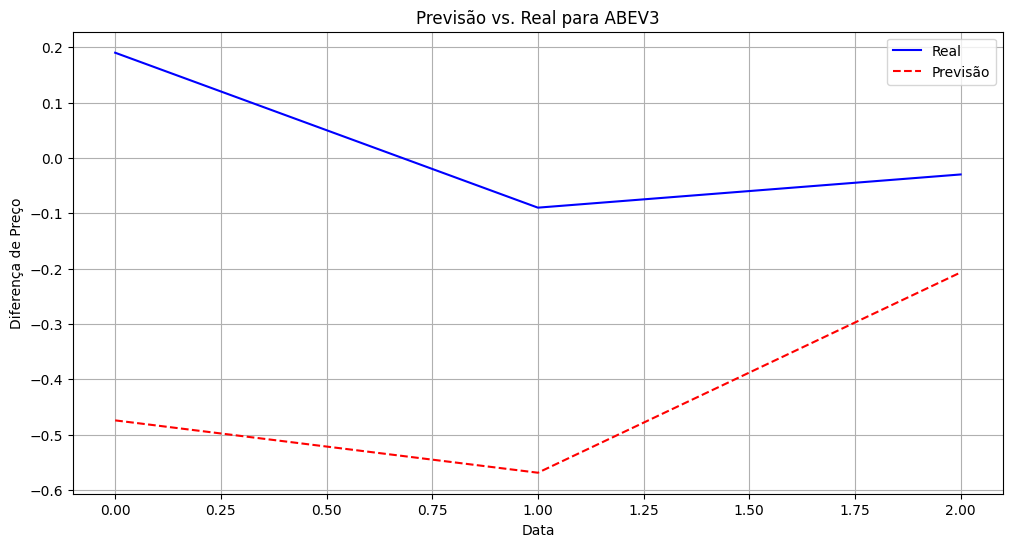

In [270]:
import matplotlib.pyplot as plt

# Exemplo de cálculo por ação (a partir do seu DataFrame final)
metricas_por_acao = resultados_avaliacao.groupby('ticker').apply(
    lambda x: pd.Series({
        'RMSE': root_mean_squared_error(x['real'], x['previsao']),
        'MAE': mean_absolute_error(x['real'], x['previsao'])
    })
)

# Imprime as métricas para as primeiras 5 ações
print(metricas_por_acao.head())

# Exemplo de visualização para uma ação
ticker_para_plotar = 'ABEV3'
df_plot = resultados_avaliacao[resultados_avaliacao['ticker'] == ticker_para_plotar]

plt.figure(figsize=(12, 6))
plt.plot(df_plot.index, df_plot['real'], label='Real', color='blue')
plt.plot(df_plot.index, df_plot['previsao'], label='Previsão', color='red', linestyle='--')
plt.title(f'Previsão vs. Real para {ticker_para_plotar}')
plt.xlabel('Data')
plt.ylabel('Diferença de Preço')
plt.legend()
plt.grid(True)
plt.show()

XGBOOST

In [271]:
preprocessor

,transformers,"[('target_encoder_ticker', ...), ('onehot_encoder_others', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,verbose,0
,cols,['ticker']
,drop_invariant,False


In [272]:
# construção do pipeline para o modelo XGboost

model_xgb = criar_pipeline(preprocessor=preprocessor, modelo_final=XGBRegressor())
model_xgb

2025-08-04 20:07:54,250 | INFO | src.model.train | Iniciando criação do pipeline completo.
2025-08-04 20:07:54,259 | INFO | src.model.train | ColumnTransformer(remainder='passthrough',
                  transformers=[('target_encoder_ticker',
                                 TargetEncoder(cols=['ticker']), ['ticker']),
                                ('onehot_encoder_others',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['tipo', 'setor', 'industria']),
                                ('numeric_features',
                                 Pip...
                                 ['Open', 'High', 'Low', 'Volum

,steps,"[('preprocessador', ...), ('modelo', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('target_encoder_ticker', ...), ('onehot_encoder_others', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [273]:
# ajuste e previsão do modelo
model_xgb.fit(X_treino, y_treino)
y_pred_xgb = model_xgb.predict(X_teste)

ValueError: A given column is not a column of the dataframe

In [ ]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

mae = mean_absolute_error(y_pred_xgb, y_teste)
rmse = root_mean_squared_error(y_pred_xgb, y_teste)
r2 = r2_score(y_pred_xgb, y_teste)
print(rmse, mae, r2)

Ranfom Forest

In [ ]:
# construção do pipeline para o modelo Random Forest Regressor
model_rf = criar_pipeline(preprocessor=preprocessor, modelo_final=RandomForestRegressor())


In [ ]:
# ajuste e previsão do modelo
model_rf.fit(X_treino, y_treino)
y_pred_rf = model_rf.predict(X_teste)

In [ ]:
mae = mean_absolute_error(y_pred_rf, y_teste)
rmse = root_mean_squared_error(y_pred_rf, y_teste)
r2 = r2_score(y_pred_rf, y_teste)
print(rmse, mae, r2)

CATBOOST

In [ ]:
# construção do pipeline para o modelo Catboost
import numpy as np
# 1. Defina as colunas numéricas e categóricas
colunas_numericas = X_treino.select_dtypes(include=np.number).columns.tolist()
colunas_categoricas = ['ticker', 'tipo', 'setor', 'industria']

# 2. Crie o pré-processador

preprocessor_catboost = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colunas_numericas),
        ('cat', 'passthrough', colunas_categoricas) 
    ],
    remainder='drop' 
)

# 3. Determine os índices das colunas categóricas
# O ColumnTransformer organiza as colunas na ordem em que foram definidas.
# As colunas numéricas (número = len(colunas_numericas)) virão primeiro,
# seguidas pelas colunas categóricas.
cat_features_indices = list(range(len(colunas_numericas), len(colunas_numericas) + len(colunas_categoricas)))

# 4. Crie a instância do modelo CatBoost
# Você pode passar o parâmetro cat_features diretamente aqui.
# Ou pode passá-lo via fit_params (vamos usar a primeira opção para ser mais direto).
catboost_model = CatBoostRegressor(
    random_state=42, 
    verbose=0,
    cat_features=cat_features_indices
)

# 5. Crie o pipeline
model_cb = Pipeline(steps=[
    ('preprocessador', preprocessor_catboost),
    ('modelo', catboost_model)
])


In [ ]:
# ajuste e previsão do modelo
model_cb.fit(X_treino, y_treino)
y_pred_cb = model_cb.predict(X_teste)

In [ ]:
mae = mean_absolute_error(y_pred_cb, y_teste)
rmse = root_mean_squared_error(y_pred_cb, y_teste)
r2 = r2_score(y_pred_cb, y_teste)
print(rmse, mae, r2)